# Calculating Cosine Similarity Based on Track Meta Data & Artist Genres

In this notebook we will generate track recommendations based on a measure of similarity between all the tracks in our library. Some of the major concepts that we'll cover include the following:

- **Multilabel Binarizer:** a method of one hot encoding (or dummying) our artist genre lists

- **Singular Value Decomposition:** a matrix decomposition operation that reduces the dimensionality of our feature matrix. We'll also use it to examine commonly oc-occurring genres

- **Cosine Similarity:** measure of similarity between two non-zero vectors

## Importing Librabries

In [50]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

%matplotlib inline

## Importing Dataset

The df_combined data includes all track meta data, artist meta data, and audio features for every song in our track library

In [51]:
df = pd.read_csv('../data/df_combined.csv')

In [52]:
df.shape

(37028, 26)

In [53]:
df.head()

,Unnamed: 0,track_id,track_name,artist_id,artist_name,album_id,album_name,playlist_id,track_popularity,track_duration,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_genres,related_artist_names,playlist_name
0,0,7DQ5CZjAQdhgDgdnSXxJ7Z,Solid Gold,6n28c9qs9hNGriNa72b26u,PNAU,3g0mfsWlOOUNheV5L3kQKs,Solid Gold,37i9dQZF1DX4dyzvuaRJ0n,58.0,208367.0,...,0.0,0.0541,0.0978,0.000001,0.0836,0.2950,104.983,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint
1,1,5p1ex0pXv6jSPJ6QbumQpD,Piece Of Your Heart,0xRXCcSX89eobfrshSVdyu,MEDUZA,0agqVZjOqVtqHkq3pTFPXb,Piece Of Your Heart,37i9dQZF1DX4dyzvuaRJ0n,87.0,152913.0,...,0.0,0.0295,0.0404,0.000160,0.0740,0.6310,124.080,[],"['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint
2,2,1ahVFh0ViDZr8LvkEVlq3B,No Sleep (feat. Bonn),60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,7KJTuTXYSnBGNgAxte3CSg,No Sleep (feat. Bonn),37i9dQZF1DX4dyzvuaRJ0n,84.0,207094.0,...,1.0,0.0326,0.1290,0.000000,0.1210,0.3270,128.133,"['big room', 'edm', 'pop', 'progressive house'...","['AREA21', 'Borgeous', 'KSHMR', 'Dimitri Vegas...",mint
3,3,6nDKrPlXdpomGBgAlO7UdP,SOS,1vCWHaC5f2uS3yhpwWbIA6,Avicii,7Jx7doYIXITyR2LQB0Hvbc,SOS,37i9dQZF1DX4dyzvuaRJ0n,95.0,157202.0,...,0.0,0.0715,0.2720,0.000000,0.1190,0.3760,100.001,"['big room', 'dance pop', 'edm', 'pop']","['Alesso', 'Afrojack', 'Swedish House Mafia', ...",mint
4,4,5TL9e2xgtvJFtNCBsq1CgX,Changa - Blanke Remix,6n28c9qs9hNGriNa72b26u,PNAU,5kwv2A2qAK8pN007hSA56t,Changa,37i9dQZF1DX4dyzvuaRJ0n,59.0,188470.0,...,1.0,0.0431,0.0330,0.119000,0.2720,0.0654,110.086,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint


Dropping extra index column

In [54]:
df.drop('Unnamed: 0', axis = 1, inplace=True)

### Creating Song/Artist Identifier

For our final recommendation system we'll want to input a track and return the most similar songs based on the Cosine Similarity score. To better identify tracks in the library, we'll create a new field which is a combination of the `track_name`, `artist_name`, and `playlist_name'. This field will become our unique identifier for a given song

In [55]:
df['track_artist_playlist'] = df['track_name']+'_'+df['artist_name']+'_'+df['playlist_name']

In [56]:
df.head()

,track_id,track_name,artist_id,artist_name,album_id,album_name,playlist_id,track_popularity,track_duration,artist_popularity,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_genres,related_artist_names,playlist_name,track_artist_playlist
0,7DQ5CZjAQdhgDgdnSXxJ7Z,Solid Gold,6n28c9qs9hNGriNa72b26u,PNAU,3g0mfsWlOOUNheV5L3kQKs,Solid Gold,37i9dQZF1DX4dyzvuaRJ0n,58.0,208367.0,65,...,0.0541,0.0978,0.000001,0.0836,0.2950,104.983,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint,Solid Gold_PNAU_mint
1,5p1ex0pXv6jSPJ6QbumQpD,Piece Of Your Heart,0xRXCcSX89eobfrshSVdyu,MEDUZA,0agqVZjOqVtqHkq3pTFPXb,Piece Of Your Heart,37i9dQZF1DX4dyzvuaRJ0n,87.0,152913.0,74,...,0.0295,0.0404,0.000160,0.0740,0.6310,124.080,[],"['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint,Piece Of Your Heart_MEDUZA_mint
2,1ahVFh0ViDZr8LvkEVlq3B,No Sleep (feat. Bonn),60d24wfXkVzDSfLS6hyCjZ,Martin Garrix,7KJTuTXYSnBGNgAxte3CSg,No Sleep (feat. Bonn),37i9dQZF1DX4dyzvuaRJ0n,84.0,207094.0,86,...,0.0326,0.1290,0.000000,0.1210,0.3270,128.133,"['big room', 'edm', 'pop', 'progressive house'...","['AREA21', 'Borgeous', 'KSHMR', 'Dimitri Vegas...",mint,No Sleep (feat. Bonn)_Martin Garrix_mint
3,6nDKrPlXdpomGBgAlO7UdP,SOS,1vCWHaC5f2uS3yhpwWbIA6,Avicii,7Jx7doYIXITyR2LQB0Hvbc,SOS,37i9dQZF1DX4dyzvuaRJ0n,95.0,157202.0,89,...,0.0715,0.2720,0.000000,0.1190,0.3760,100.001,"['big room', 'dance pop', 'edm', 'pop']","['Alesso', 'Afrojack', 'Swedish House Mafia', ...",mint,SOS_Avicii_mint
4,5TL9e2xgtvJFtNCBsq1CgX,Changa - Blanke Remix,6n28c9qs9hNGriNa72b26u,PNAU,5kwv2A2qAK8pN007hSA56t,Changa,37i9dQZF1DX4dyzvuaRJ0n,59.0,188470.0,65,...,0.0431,0.0330,0.119000,0.2720,0.0654,110.086,"['alternative dance', 'aussietronica', 'austra...","['Eye of the Enemy', 'Cypecore', 'Rise to Fall...",mint,Changa - Blanke Remix_PNAU_mint


### Creating Final Dataframe

In [57]:
final_cols = ['track_id', 'track_popularity', 'track_artist_playlist',
       'artist_popularity', 'artist_genres',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

In [58]:
df_final = df[final_cols]

In [59]:
df_final.head()

,track_id,track_popularity,track_artist_playlist,artist_popularity,artist_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,7DQ5CZjAQdhgDgdnSXxJ7Z,58.0,Solid Gold_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.567,0.946,5.0,-2.245,0.0,0.0541,0.0978,0.000001,0.0836,0.2950,104.983
1,5p1ex0pXv6jSPJ6QbumQpD,87.0,Piece Of Your Heart_MEDUZA_mint,74,[],0.677,0.744,10.0,-6.806,0.0,0.0295,0.0404,0.000160,0.0740,0.6310,124.080
2,1ahVFh0ViDZr8LvkEVlq3B,84.0,No Sleep (feat. Bonn)_Martin Garrix_mint,86,"['big room', 'edm', 'pop', 'progressive house'...",0.440,0.635,11.0,-6.385,1.0,0.0326,0.1290,0.000000,0.1210,0.3270,128.133
3,6nDKrPlXdpomGBgAlO7UdP,95.0,SOS_Avicii_mint,89,"['big room', 'dance pop', 'edm', 'pop']",0.802,0.645,5.0,-6.181,0.0,0.0715,0.2720,0.000000,0.1190,0.3760,100.001
4,5TL9e2xgtvJFtNCBsq1CgX,59.0,Changa - Blanke Remix_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.530,0.789,9.0,-5.546,1.0,0.0431,0.0330,0.119000,0.2720,0.0654,110.086


### Set track_id to Index

As track_id is the unique identifier in our dataframe, we'll set this feature as the index

In [60]:
df_final.set_index('track_id', inplace=True)
df_final.head()

,track_popularity,track_artist_playlist,artist_popularity,artist_genres,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
track_id,,,,,,,,,,,,,,,
7DQ5CZjAQdhgDgdnSXxJ7Z,58.0,Solid Gold_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.567,0.946,5.0,-2.245,0.0,0.0541,0.0978,0.000001,0.0836,0.2950,104.983
5p1ex0pXv6jSPJ6QbumQpD,87.0,Piece Of Your Heart_MEDUZA_mint,74,[],0.677,0.744,10.0,-6.806,0.0,0.0295,0.0404,0.000160,0.0740,0.6310,124.080
1ahVFh0ViDZr8LvkEVlq3B,84.0,No Sleep (feat. Bonn)_Martin Garrix_mint,86,"['big room', 'edm', 'pop', 'progressive house'...",0.440,0.635,11.0,-6.385,1.0,0.0326,0.1290,0.000000,0.1210,0.3270,128.133
6nDKrPlXdpomGBgAlO7UdP,95.0,SOS_Avicii_mint,89,"['big room', 'dance pop', 'edm', 'pop']",0.802,0.645,5.0,-6.181,0.0,0.0715,0.2720,0.000000,0.1190,0.3760,100.001
5TL9e2xgtvJFtNCBsq1CgX,59.0,Changa - Blanke Remix_PNAU_mint,65,"['alternative dance', 'aussietronica', 'austra...",0.530,0.789,9.0,-5.546,1.0,0.0431,0.0330,0.119000,0.2720,0.0654,110.086


### Checking Null Values

In [61]:
df_final.isnull().sum().sort_values(ascending = False)

tempo                    5830
valence                  5830
liveness                 5830
instrumentalness         5830
acousticness             5830
speechiness              5830
mode                     5830
loudness                 5830
key                      5830
energy                   5830
danceability             5830
track_artist_playlist       5
artist_genres               0
artist_popularity           0
track_popularity            0
dtype: int64

We that we indeed have several songs where we're missing audio feature data. This is somewhat expected as Spotify doesn't make audio features available for all songs. Rather than attempting to impute these values, we'll drop these rows

In [62]:
df_final.dropna(inplace=True)
df_final.shape

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(31194, 15)

We know have 32K tracks in our song library

## One Hot Encoding Artist Genres List

First we'll remove any tracks where the artist_genre list is empty

In [63]:
index_missing_genres = df_final[df_final.artist_genres == '[]'].index

In [64]:
df_final.drop(index = index_missing_genres, axis = 0, inplace = True)
df_final.shape

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(26887, 15)

After dropping tracks where the artist genres list is missing, we have 27K songs in the library

Now we'll need to convert our genre list back to a Python list, currently it is a string containing a list

In [65]:
import ast

df_final['artist_genres_list'] = df_final['artist_genres'].map(lambda x: ast.literal_eval(x))

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Dropping original `artist_genres`

In [66]:
df_final_genres = df_final.drop(['artist_genres','track_artist_playlist'], axis = 1)

In [67]:
df_final_genres.head()

,track_popularity,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_genres_list
track_id,,,,,,,,,,,,,,
7DQ5CZjAQdhgDgdnSXxJ7Z,58.0,65,0.567,0.946,5.0,-2.245,0.0,0.0541,0.097800,0.000001,0.0836,0.2950,104.983,"[alternative dance, aussietronica, australian ..."
1ahVFh0ViDZr8LvkEVlq3B,84.0,86,0.440,0.635,11.0,-6.385,1.0,0.0326,0.129000,0.000000,0.1210,0.3270,128.133,"[big room, edm, pop, progressive house, tropic..."
6nDKrPlXdpomGBgAlO7UdP,95.0,89,0.802,0.645,5.0,-6.181,0.0,0.0715,0.272000,0.000000,0.1190,0.3760,100.001,"[big room, dance pop, edm, pop]"
5TL9e2xgtvJFtNCBsq1CgX,59.0,65,0.530,0.789,9.0,-5.546,1.0,0.0431,0.033000,0.119000,0.2720,0.0654,110.086,"[alternative dance, aussietronica, australian ..."
2UkF0EWfh0T90ScJzGqnD1,71.0,65,0.427,0.916,4.0,-3.716,0.0,0.1160,0.000156,0.000005,0.1540,0.6880,123.539,"[deep groove house, house, tropical house]"


### One Hot Encoding with MultiLabelBinarizer

The Multilabel Binarizer will iterate through our list and allow us to one hot encode the items in our newly created `artist_genres_list`

One thing to note is that we'll append this one hot encoded genre matrix as a Sparse dataframe. Sparse dataframes contain mostly zeros. Stored apprpriate data in a sparse matrix allow the matrix to be stored more efficiently, and typically speed up machine learning processes

In [68]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
df_final_genres_pop = df_final_genres.join(pd.DataFrame(mlb.fit_transform(df_final_genres.pop('artist_genres_list')),
                          columns=mlb.classes_,
                          index=df_final_genres.index))

In [69]:
df_final_genres.shape

(26887, 13)

The resulting data frame now has 1,922 features including all one hot encoded genres and the track/artist meta data

## Singular Value Decomposition

Singular Value Decomposition (SVD) is a dimensionality reduction technique in linear algebra that factorizes any matrix M into the product of 3 separate matrices. The ultimate goal being to reduce a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

The technique is widely used in the context of Natural Language Processing (NLP) as well. Topic modeling is the process of discovering groups of co-occurring words in text documents. These groups co-occurring words makes are related in some way, and can be considered 'topics'.

In this analysis, we'll use SVD to both reduce the dimensionalty of our track dataframe and as a means of analyzing commonly co-occurring artist genres to infor future recommendations.

### A Little Glimpse of the Linear Algebra Behind SVD

- This is very similar to an eigendecomposition, which is 
$$X = S\Lambda S^T$$

- This is similar but for non-square matrices.
 

- Factors matrix into the product of three matrices

  $$X = USV^T$$
  
- $m$ is the number of documents
- $n$ is the number of terms
- $U$ is $m\times n$, which are analogous to the eigenvectors in PCA
- $S$ is $n\times n$, which is analgous to the eigenvalues in PCA
- $V$ is $n\times n$

### Scaling the Data

Scaling the data means that we will transform the data so that each feature will have a mean of 0 and a standard deviation of 1. As many of our features have quite different magnitudes, we'll scale our data prior to the SVD trnasformation

In [70]:
ss = StandardScaler()
df_final_genres_pop_ss = ss.fit_transform(df_final_genres_pop)

/Users/davidbickham/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/davidbickham/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Creating SVD Matrix

The resulting matrix will represent our data in a lower dimensional space of n_components (which we'll specify). We'll start by computing a matrix of 100 components

In [71]:
SVD = TruncatedSVD(n_components=100, random_state=20)
svd_matrix = SVD.fit_transform(df_final_genres_pop_ss)
svd_matrix.shape

(26887, 100)

In [72]:
SVD.components_.shape

(100, 1922)

## Plotting Explained Variance

We can visualize the amount of cumulative variance in our data that is explained by each subsequent component created via SVD

Text(0, 0.5, 'variance ratio')

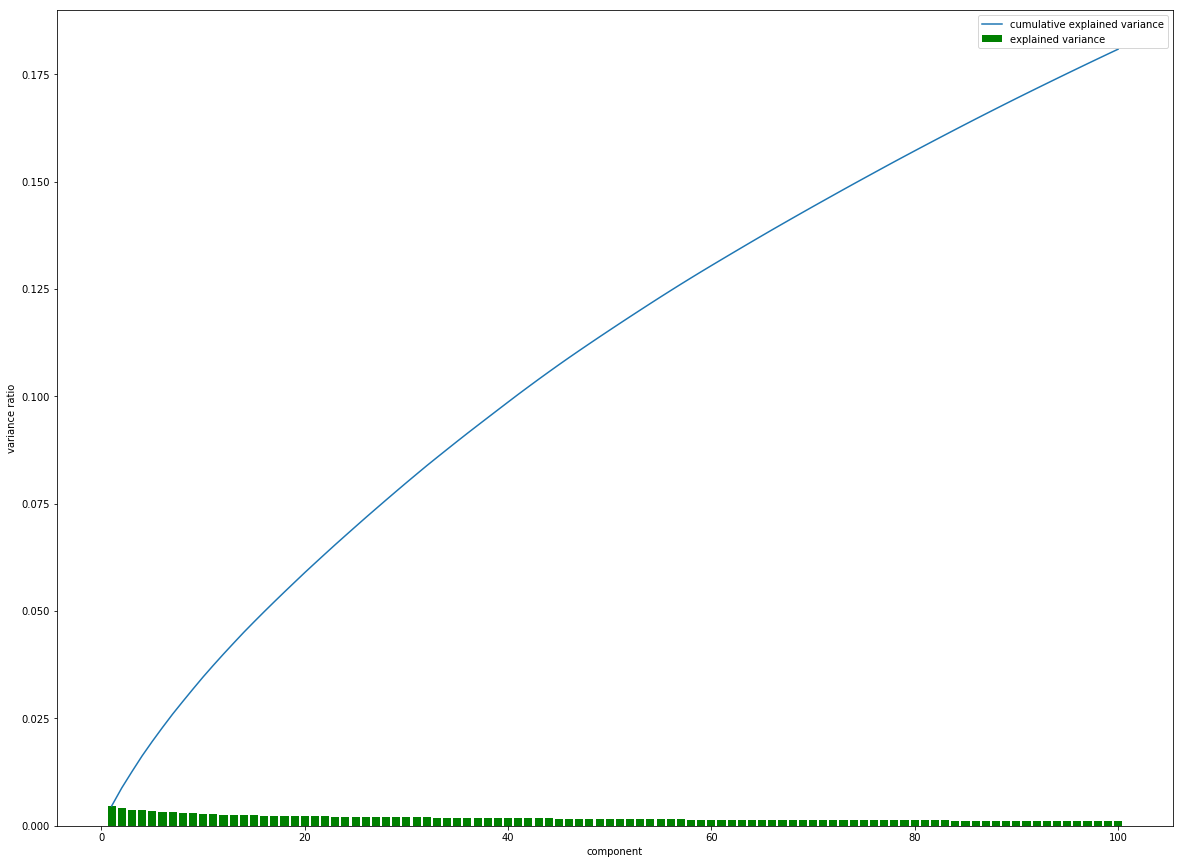

In [73]:
fig = plt.figure(figsize=(20,15))
plt.bar(np.array(range(100))+1, 
        SVD.explained_variance_ratio_, 
        color='g', 
        label='explained variance')
plt.plot(np.array(range(100))+1, 
         np.cumsum(SVD.explained_variance_ratio_), 
         label='cumulative explained variance')
plt.legend()
plt.xlabel('component')
plt.ylabel('variance ratio')

We can see that the first 100 components we've calculated explain roughly 18% of the variance in our tracks data set

In [74]:
component_names = ["component_"+str(i+1) for i in range(100)]
svd_df = pd.DataFrame(svd_matrix,
                      columns=component_names)

svd_df.insert(0, 'track_id', df_final_genres.index)
svd_df.set_index('track_id', inplace=True)

In [75]:
svd_df.head()

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
track_id,,,,,,,,,,,,,,,,,,,,,
7DQ5CZjAQdhgDgdnSXxJ7Z,2.035596,-1.496917,3.776113,0.263415,-0.646796,-1.530263,-1.714502,1.211791,1.207300,-1.151620,...,-0.516145,0.015262,1.043404,1.380739,-1.910107,-0.571241,-1.162905,-1.610178,0.504680,-1.392331
1ahVFh0ViDZr8LvkEVlq3B,-1.428473,-1.617124,1.549980,-0.010941,-0.905047,-4.546911,-1.892264,0.433461,2.388239,0.349556,...,-0.149239,-0.250272,-0.120992,0.209218,0.074228,0.148952,-0.134051,-0.102124,0.036275,0.063159
6nDKrPlXdpomGBgAlO7UdP,-1.389994,-1.445927,1.174145,-0.618994,-1.308264,-2.519386,-1.150983,0.243227,1.762597,0.086157,...,-0.255130,-0.237189,-0.127342,0.288158,-0.007890,0.202737,-0.247919,-0.110277,-0.074902,0.034823
5TL9e2xgtvJFtNCBsq1CgX,2.134044,-1.347201,3.761819,0.312336,-0.329945,-1.487206,-1.727162,1.120685,1.290717,-1.125561,...,-0.505074,0.004686,1.017220,1.358216,-1.891037,-0.570223,-1.185873,-1.621412,0.535278,-1.333220
2UkF0EWfh0T90ScJzGqnD1,-1.143085,-1.312320,1.019998,0.263606,-0.699662,-3.101817,-0.873020,0.383978,0.889724,0.147576,...,0.501551,-0.162140,-0.232025,-0.378920,0.494639,0.426026,-0.254900,0.102184,0.621775,-0.094697


In [76]:
svd_df.shape

(26887, 100)

## Topic Modeling - Analzying our Component Features

Below we'll examine some of the features that encompass a given component. This will give us an indication of how well we'll able to identify commonly co-occurring genres/ track features

#### Creating a Dataframe of our Component/Feature Values

In [77]:
loadings = pd.DataFrame(SVD.components_,
                        index=component_names,
                        columns=df_final_genres_pop.columns).T

Appending the absoulte value of each of the component values

In [78]:
loadings['abs_component_1'] = np.abs(loadings.component_1)
loadings['abs_component_2'] = np.abs(loadings.component_2)
loadings['abs_component_3'] = np.abs(loadings.component_3)
loadings['abs_component_4'] = np.abs(loadings.component_4)
loadings['abs_component_5'] = np.abs(loadings.component_5)
loadings['abs_component_6'] = np.abs(loadings.component_6)
loadings['abs_component_7'] = np.abs(loadings.component_7)
loadings['abs_component_8'] = np.abs(loadings.component_8)
loadings['abs_component_9'] = np.abs(loadings.component_9)
loadings['abs_component_10'] = np.abs(loadings.component_10)

#### Component 1 Features

In [79]:
loadings.sort_values('abs_component_1',ascending=False).head(10)[['component_1']]

,component_1
noise pop,0.198889
lo-fi,0.196611
indie rock,0.193215
experimental rock,0.172082
dream pop,0.170945
post-punk,0.165277
noise rock,0.163242
alternative rock,0.162757
new wave,0.159271
art rock,0.147974


The first component seems to be genres related to softer rock/pop.

#### Component 2 Features

In [80]:
loadings.sort_values('abs_component_2',ascending=False).head(10)[['component_2']]

,component_2
jazz,0.294913
cool jazz,0.292676
bebop,0.290596
contemporary post-bop,0.273456
hard bop,0.261228
soul jazz,0.221199
free jazz,0.199837
jazz fusion,0.191700
big band,0.184184
avant-garde jazz,0.181977


Clearly a jazz related component

#### Component 3 Features

In [81]:
loadings.sort_values('abs_component_3',ascending=False).head(10)[['component_3']]

,component_3
classic rock,-0.209970
folk rock,-0.199245
mellow gold,-0.197104
album rock,-0.190874
rock,-0.180864
soft rock,-0.171699
roots rock,-0.153194
hard rock,-0.144002
blues-rock,-0.141747
southern rock,-0.140832


Different variations of rock

#### Component 4 Features

In [82]:
loadings.sort_values('abs_component_4',ascending=False).head(10)[['component_4']]

,component_4
death metal,0.232647
groove metal,0.198087
metal,0.197140
deathgrind,0.181530
brutal death metal,0.173836
speed metal,0.173045
black metal,0.164973
pagan black metal,0.142966
alternative metal,0.142279
symphonic black metal,0.141416


All things metal

#### Component 5 Features

In [83]:
loadings.sort_values('abs_component_5',ascending=False).head(10)[['component_5']]

,component_5
rap,-0.181957
hip hop,-0.179599
pop rap,-0.173294
southern hip hop,-0.154189
loudness,-0.149933
acousticness,0.143515
gangster rap,-0.138560
energy,-0.137798
trap music,-0.134104
instrumentalness,0.116722


This is primarily a rap/hip-hop component. Interestingly we also see track features such as `loudness`, `acousticness`, and `energy`. This indicates that tracks in this genre have some unique values in these categories that dstinguish them from other genres. We can assume that levels of `acousticness` and `instrumentalness` are near zero for these tracks

In [84]:
loadings.sort_values('abs_component_6',ascending=False).head(10)[['component_6']]

,component_6
edm,-0.240771
electro house,-0.240231
big room,-0.220829
progressive house,-0.210193
progressive electro house,-0.202427
house,-0.184803
deep big room,-0.172378
pop edm,-0.161100
tropical house,-0.147362
hip hop,0.138429


The house head component, right up my alley! :)

## Calculating Cosine Similarity

The below code will return a square matrix, comparing every track with every other track in the dataset and calculating a similarity measure between each

In [85]:
cos_sim_mat = cosine_similarity(svd_matrix, svd_matrix)
cos_sim_mat.shape

(26887, 26887)

In [86]:
print(cos_sim_mat)

[[ 1.          0.11526319  0.16765327 ... -0.04640881 -0.04688546
  -0.04414725]
 [ 0.11526319  1.          0.90179613 ... -0.0448808  -0.05067367
  -0.0304473 ]
 [ 0.16765327  0.90179613  1.         ... -0.0765136  -0.07770339
  -0.05699619]
 ...
 [-0.04640881 -0.0448808  -0.0765136  ...  1.          0.99934328
   0.99878057]
 [-0.04688546 -0.05067367 -0.07770339 ...  0.99934328  1.
   0.99862993]
 [-0.04414725 -0.0304473  -0.05699619 ...  0.99878057  0.99862993
   1.        ]]


### Next We'll Make Some Dictionaries to Lookup Meta Data on Each Track

The below dictionary will be used to reference the track name, artist name, and playlist name of every song in the library

In [87]:
track_lookup = dict(zip(df_final_genres.index, df_final['track_artist_playlist']))

Next we'll create a dictionary that provides the index of each song in the SVD dataframe

In [88]:
ind_track = dict(zip(range(svd_df.shape[0]), svd_df.index))

Next we'll align track lookup dictionary with the index values in our svd dataframe

In [89]:
track_artist_ind = dict(zip([track_lookup[ind_track[x]] for x in ind_track], ind_track))

### Function to Calculate Feature Similarity

In [90]:
def feat_sim(track_artist_ind, k=20, cos_sim_mat=cos_sim_mat):
    '''
    Returns array of indices for top k tracks with the greatest similarity to given track, along with 
    their similarity rating, based on precomputed cosine similarity of feature vectors.

    '''
    top_tracks = np.argsort(cos_sim_mat[track_artist_ind])[-2:-(k+2):-1]
    top_tracks_sim = np.sort(cos_sim_mat[track_artist_ind])[-2:-(k+2):-1]

    return top_tracks, top_tracks_sim

# Source: Douglas Strodtman - General Assembly DSI Instructor

Example for one song in the library

In [91]:
feat_sim(track_artist_ind['Solid Gold_PNAU_mint'])

(array([    8,  9874,     3,  1633,  1643,  6828,  1600,  1630,  9869,
         8127,  8937,  2121, 12305, 12816, 20242, 18727, 20254, 12814,
        19562,  9703]),
 array([0.99962592, 0.99918907, 0.99875921, 0.99847021, 0.89080946,
        0.89047976, 0.89010544, 0.88992822, 0.8889244 , 0.88889794,
        0.88697687, 0.87282714, 0.86980277, 0.86828655, 0.86812805,
        0.86690958, 0.86690275, 0.86641638, 0.86577787, 0.86568644]))

### Function to Return DataFrame of k Most Similar Tracks

In [92]:
def get_recs(track_artist, k=20, cos_sim_mat=cos_sim_mat):
    try:
        top_tracks, top_tracks_sim = feat_sim(track_artist_ind[track_artist], k, cos_sim_mat)
        return pd.DataFrame([[track_lookup[ind_track[x]] for x in top_tracks], 
                             list(top_tracks_sim)], 
                            
                            index=['Track_Artist', 'Similarity']).T
    except:
        print('No results available for that title. Check your spelling.')
        
# Source: Douglas Strodtman - General Assembly DSI Instructor

## Generating Recommendations

The below code will allow us to search either the name of a track, artist, or playlist and retrieve the first 20 songs that match our search criteria.

We can then use these values to feed into our `get_recs` function to get a list of the top 20 most similar songs.

In [93]:
df_final[df_final.track_artist_playlist.str.contains("Kanye")]['track_artist_playlist'].head(20)

track_id
6vWEAOUSxohKxhp0K1BsxL    Mixed Personalities (feat. Kanye West)_YNW Mel...
4S8d14HvHb70ImctNgVzQQ          I Love It (& Lil Pump)_Kanye West_Get Turnt
1oJ8EDr2pv94IvSd6ZmDgo    MAMA (feat. Nicki Minaj, Kanye West)_6ix9ine_S...
2kNtAwWATYkqV3CdT20RV0    Swagga Like Us (feat. Kanye West & Lil' Wayne)...
34KUIBsIUiPV7oCIzSdDAU    Diamonds From Sierra Leone - Remix_Kanye West_...
4cAgkb0ifwn0FSHGXnr4F6                   New Slaves_Kanye West_Ill Lyricist
42GcjriRK6srwHkfbkBqVl          Blood On The Leaves_Kanye West_Ill Lyricist
7eW9cHOAHmYqphs5tWXETw                       Clique_Kanye West_Ill Lyricist
6K07Ahf6V7CAQn0ikrOztl                  So Appalled_Kanye West_Ill Lyricist
1QhLQckXvwSnwDV0lmLrYy                      The One_Kanye West_Ill Lyricist
5nIu0VwPOsjkF61zfevLKh            Hold My Liquor_Kanye West_Clinically Cold
12D0n7hKpPcjuUpcbAKjjr              Don't Like.1_Kanye West_Clinically Cold
1ZHYJ2Wwgxes4m8Ba88PeK                   Monster_Kanye West_Clinically Cold
3U2

#### Let's try out a few! First we'll start with the Kanye West track 'Waves' found on the G.O.O.D. Music playlist

In [94]:
get_recs('Waves_Kanye West_G.O.O.D. Music')

,Track_Artist,Similarity
0,Runaway_Kanye West_G.O.O.D. Music,0.995649
1,Bound 2_Kanye West_Run This Town 150–165 BPM,0.993776
2,I Wonder_Kanye West_G.O.O.D. Music,0.993664
3,Can't Tell Me Nothing_Kanye West_Throwback Wor...,0.992393
4,New Slaves_Kanye West_Ill Lyricist,0.99151
5,Ghost Town_Kanye West_G.O.O.D. Music,0.991428
6,All Of The Lights_Kanye West_G.O.O.D. Music,0.986967
7,Blood On The Leaves_Kanye West_Ill Lyricist,0.986621
8,Monster_Kanye West_Clinically Cold,0.986513
9,Hold My Liquor_Kanye West_Clinically Cold,0.985209


Based on the results we can some interesting findings. In this case, all of our recommendations are other Kanye West tracks, many of which are also on the same playlist. Keep in mind that Kanye overindexes on the number of tracks in the library due to his popularity.

Let's check another popular artist like Lady Gaga:

In [95]:
df_final[df_final.track_artist_playlist.str.contains("Gaga")]['track_artist_playlist'].head(20)

track_id
2VxeLyX666F8uXCJ0dZF8B                       Shallow_Lady Gaga_Mega Hit Mix
2kecdnlyueotEMC8rdNlf6                          Joanne_Lady Gaga_Hit Rewind
6QfS2wq5sSC1xAJCQsTSlj       Shallow - Radio Edit_Lady Gaga_Just Good Music
1koJk8rrMBlhDZ8MNiLzH9    Always Remember Us This Way_Lady Gaga_Soft Pop...
2rbDhOo9Fh61Bbu23T2qCk    Always Remember Us This Way_Lady Gaga_Everyday...
3DKpA54hrFIdPN6AtL9HXa    I'll Never Love Again - Film Version - Radio E...
6DO29wBOfESk3C2sScpxZn    Don't Let Me Be Misunderstood (feat. Lady Gaga...
1j8jHKgAQ7QD52Wd5uuLNZ    Joanne (Where Do You Think You're Goin'?) - Pi...
0fJtP2HkuZtzfh30XIMtPw               Your Song_Lady Gaga_LADY GAGA / JOANNE
34oB5r0lcN3fYWCs2uA1k5                The Cure_Lady Gaga_LADY GAGA / JOANNE
7dZ1Odmx9jWIweQSatnRqo         Million Reasons_Lady Gaga_LADY GAGA / JOANNE
3d0VZU6Mf2hdZRHA4zry8S              John Wayne_Lady Gaga_LADY GAGA / JOANNE
56ZrTFkANjeAMiS14njg4E        Perfect Illusion_Lady Gaga_LADY GAGA / JOANNE
6Az

In [96]:
get_recs('Shallow - Radio Edit_Lady Gaga_Just Good Music')

,Track_Artist,Similarity
0,Million Reasons_Lady Gaga_LADY GAGA / JOANNE,0.997243
1,Shallow_Lady Gaga_Mega Hit Mix,0.996826
2,I'll Never Love Again - Film Version - Radio E...,0.988549
3,I'll Never Love Again - Film Version_Lady Gaga...,0.988036
4,needy_Ariana Grande_Pop Rising,0.985712
5,Is That Alright?_Lady Gaga_Piano Ballads,0.983563
6,Your Song_Lady Gaga_LADY GAGA / JOANNE,0.982567
7,Angel Down - Work Tape_Lady Gaga_LADY GAGA / J...,0.981309
8,When I Was Your Man_Bruno Mars_Feeling Down,0.98073
9,"Fire On Fire - From ""Watership Down""_Sam Smith...",0.980266


Interestingly, in the case of another artist with a large number of songs in the library, the recommendations are actually a bit more divers. 

We clearly see a number of Gaga songs but we also see several tracks from other popular artist like Ariana Grande, Bruno Mars, and Sam Smith.

Let's check out a less popular artist

We'll check out recommendations for one of my favorite artist, Jordan Rakei. Jordan's is an R&B singer from the UK and his sound is a bit more neo-soul, indie R&B, and jazzy (great stuff, check him out!)

In [97]:
df_final[df_final.track_artist_playlist.str.contains("Rakei")]['track_artist_playlist'].head(20)

track_id
4nSO7iKiwPj4wJjylLCu0s         Say Something_Jordan Rakei_Ready for the Day
3UYKvI6JYzkp8eep9fcWT0                       Mind’s Eye_Jordan Rakei_Butter
6pGfvCQksyQLuXrXktE0wu    The Self (feat. Jordan Rakei)_Richard Spaven_J...
Name: track_artist_playlist, dtype: object

In [98]:
get_recs('Mind’s Eye_Jordan Rakei_Butter')

,Track_Artist,Similarity
0,Say Something_Jordan Rakei_Ready for the Day,0.992687
1,Show the Way_Moonchild_Soul Coffee,0.951631
2,A Fool for You_Aaron Taylor_Ready for the Day,0.950138
3,90 Degrees_Yazmin Lacey_Jazz UK,0.949131
4,Needy Bees_Nick Hakim_Mellow Mood,0.94904
5,Bet She Looks Like You_Nick Hakim_Mellow Mood,0.94891
6,I Don't Know_Nick Hakim_Late Night Vibes,0.946306
7,You're The Reason Why_Aaron Taylor_I Love My N...,0.946263
8,Get To Know It_Moonchild_Soul Coffee,0.945774
9,Get Through This_Aaron Taylor_Ready for the Day,0.942066


Here we can see that other Jordan Rakei songs are first in the recommendations, while many of the other songs are right in line with his musical aesthetic. Playlists of some of the recommendations include Soul Coffee, Jazz UK, and Mellow Mood